# Timing correction and speed control demo in spiking network

Conductance-based LIF network:

$$C_m^i \frac{dv^i}{dt} = g_l[E_l^i - V^i(t)] + g^i_e(t)[E_e - V^i(t)] + g^i_i(t)[E_i - V^i(t)] + I^i_{ext}(t)$$

The time-varying conductances $g^i_e$ and $g^i_i$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$ respectively.

All param values are in SI units, with capacitance and conductance per cm$^2$.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## MODEL
M = Generic(
    # E membrane
    C_M_E=1e-6, G_L_E=.1e-3,  # T_M (s) = C_M (F/cm^2) / G_L (S/cm^2)
    E_L_E=-.06, V_TH_E=-.05, T_R_E=1,
    
    # I membrane
    #C_M_I=1e-6, G_L_E=.1e-3, 
    #E_L_I=-.06, V_TH_E=-.05, T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, T_E=.002, T_I=.002,
    
    # architecture
    N_L=200,  # num links
    N_L_E=30,  # num E nrns per link
    W_E_E_R=.005e-3,  # E->E w/in-link cxns (S/cm^2)
    W_E_E_F=.01e-3,  # E feed-fwd cxns btwn links (S/cm^2)
    SGM_N=.5e-9,  # noise std factor (Amp*sqrt(s))
    
    # modulation control
    V_F=1.2, W=.4, H=.4, T_P_CH=.04,
    T_P_CH_ADJ=1, X_P_CH_ADJ=1,
    FQ_SPK_U_I=800, W_U_E_I=.05e-3,
    )

## SMLN
S = Generic(RNG_SEED=None, DT=.0005, T=.4)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')
# print('T_M_I =', 1000*M.C_M_I/M.G_L_I, 'ms')

T_M_E = 10.0 ms


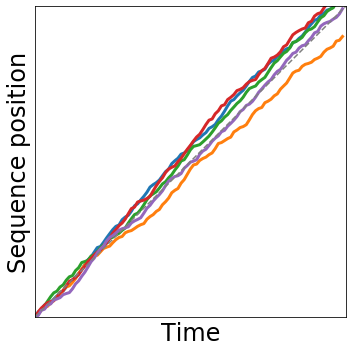

In [2]:
np.random.seed(6)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

t2x = []

for _ in range(5):
    x = np.nan * np.zeros(100)
    x[0] = 0
    
    for t in range(1, 100):
        dx = 1 + np.random.uniform(-.75, .75)
        x[t] = x[t-1] + dx
        
    ax.plot(x, lw=3)
    
ax.plot([0, 100], [0, 100], ls='--', c='gray')

ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Time')
ax.set_ylabel('Sequence position')

set_font_size(ax, 24)

fig.savefig('cosyne_poster_figs/fig3a.svg')

# Spatiotemporally modulated spike sequence

In [3]:
# set up modulatory signal
def to_ch_units(v_f_ch, v_s_ch, v_f, w, h, t_p_ch, t_p_ch_adj=1, x_p_ch_adj=1, verbose=False):
    """Convert unitless params to units of chain links and seconds.
    
    :param v_f_ch: fast chain speed (links/sec)
    :param v_s_ch: slow chian speed (links/sec)
    :param v_f: fast speed (unitless)
    :param w: temporal czone width (btwn 0 and 1)
    :param h: spatial czone width (btwn 0 and 1)
    :param t_p_ch: temporal chain period (sec)
    :param t_p_ch_adj: factor to multiply t_p_ch by to adjust speed (unitless near 1)
    
    """
    v_ch = v_f_ch / v_f  # stable speed in chain links / sec
    x_p_ch = v_ch * t_p_ch  # spatial period in chain links
    w_ch = t_p_ch * w
    h_ch = x_p_ch * h
    
    v_s = v_f * (v_s_ch/v_f_ch)
    
    # adjust temporal period
    t_p_ch *= t_p_ch_adj
    w_ch *= t_p_ch_adj
    
    # adjust spatial period
    x_p_ch *= x_p_ch_adj
    h_ch *= x_p_ch_adj
    
    if verbose:
        print('v_ch = {0:.3f} links/s'.format(v_ch))
        print('x_p_ch = {0:.3f} links'.format(x_p_ch))
        print('t_p_ch = {0:.3f} s'.format(t_p_ch))
        print('w_ch = {0:.3f} s'.format(w_ch))
        print('h_ch = {0:.3f} links'.format(h_ch))
    
    return Generic(
        v_f=v_f, v_s=v_s, w=w, h=h,
        v_f_ch=v_f_ch, v_s_ch=v_s_ch, v_ch=v_ch, x_p_ch=x_p_ch, t_p_ch=t_p_ch, w_ch=w_ch, h_ch=h_ch)


def plot_czone(ctl_prm, m=M, s=S, figsize=(12, 10), gs=None):
    
    t = np.arange(0, s.T, s.DT)
    x = np.arange(0, m.N_L, .01)

    a = .5 * (signal.square((2*np.pi/ctl_prm.t_p_ch)*t, ctl_prm.w) + 1)
    b = .5 * (signal.square((2*np.pi/ctl_prm.x_p_ch)*x, ctl_prm.h) + 1)

    gs = gridspec.GridSpec(6, 6) if gs is None else gs
    fig = plt.figure(figsize=figsize, tight_layout=True)
    axs = [fig.add_subplot(gs[0, :-1]), fig.add_subplot(gs[1:, -1]), fig.add_subplot(gs[1:, :-1])]

    axs[0].plot(t, a, c='b', lw=2)
    axs[0].fill_between(t, np.zeros(len(a)), a, color='b', alpha=.3)
    axs[0].set_xlim(0, s.T)
    axs[0].set_ylim(-.1, 1.1)

    axs[0].set_xticks([])
    axs[0].set_yticks([0, 1])
    axs[0].set_xlabel('Temporal modulation a(t)', color='b')
    axs[0].xaxis.set_label_position('top') 

    axs[1].plot(b, x, c='r', lw=2)
    axs[1].fill_betweenx(x, np.zeros(len(x)), b, color='r', alpha=.3)
    axs[1].set_ylim(0, m.N_L)
    axs[1].set_xlim(-.1, 1.1)

    axs[1].set_yticks([])
    axs[1].set_xticks([0, 1])
    axs[1].set_ylabel('Spatial modulation b(x)', color='r')
    axs[1].yaxis.set_label_position('right')

    for t_ in np.arange(0, s.T, ctl_prm.t_p_ch):
        for x_ in np.arange(0, m.N_L, ctl_prm.x_p_ch):
            axs[2].fill_between(
                [t_, t_+ctl_prm.w_ch], [x_]*2, [x_+ctl_prm.h_ch]*2,
                color='violet', alpha=.3, zorder=0)

    axs[2].set_xlim(0, s.T)
    axs[2].set_ylim(0, m.N_L)
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Link number x')

    for ax in axs:
        set_font_size(ax, 16)
        
    return fig, axs

## Correction zone geometry

Note there will be an additional effective lag to the temporal czone width due to the cellular membrane time constant.

v_ch = 970.833 links/s
x_p_ch = 38.833 links
t_p_ch = 0.040 s
w_ch = 0.016 s
h_ch = 15.533 links


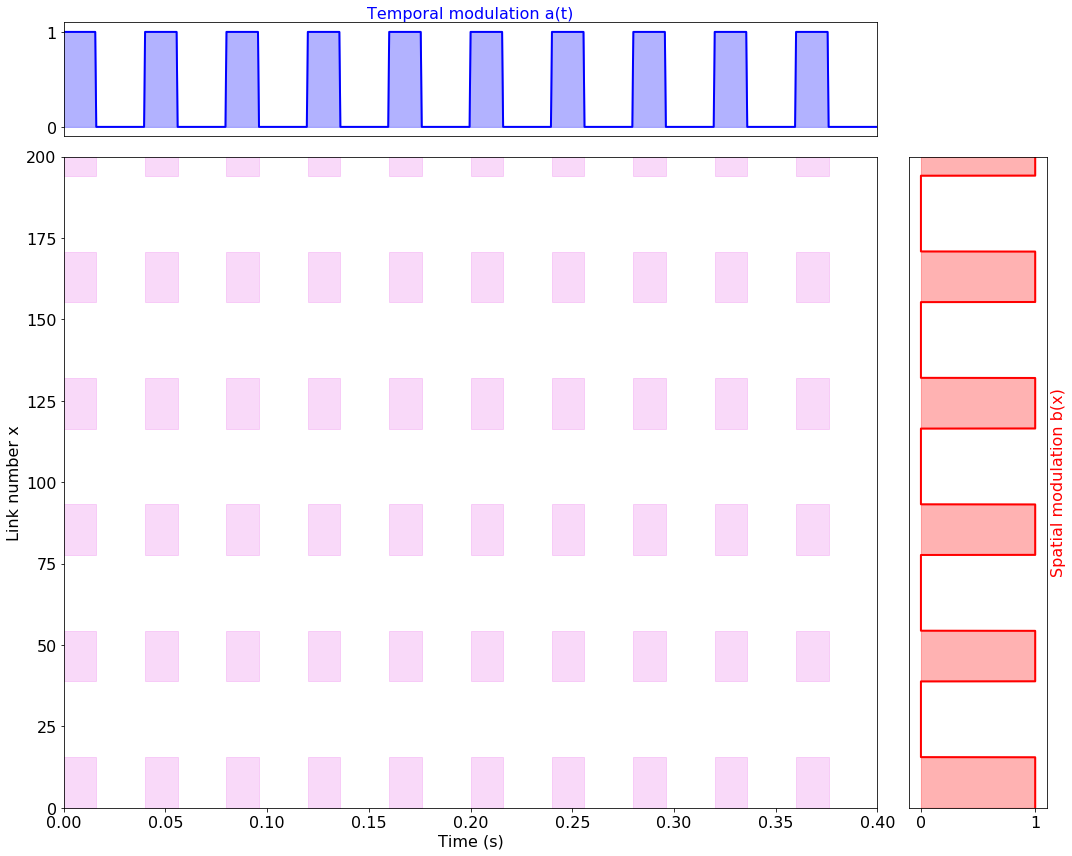

In [4]:
plot_czone(
    ctl_prm=to_ch_units(v_f_ch=1165, v_s_ch=570, v_f=M.V_F, w=M.W, h=M.H, t_p_ch=M.T_P_CH, verbose=True),
    figsize=(15, 12));

v_ch = 970.833 links/s
x_p_ch = 38.833 links
t_p_ch = 0.040 s
w_ch = 0.016 s
h_ch = 15.533 links


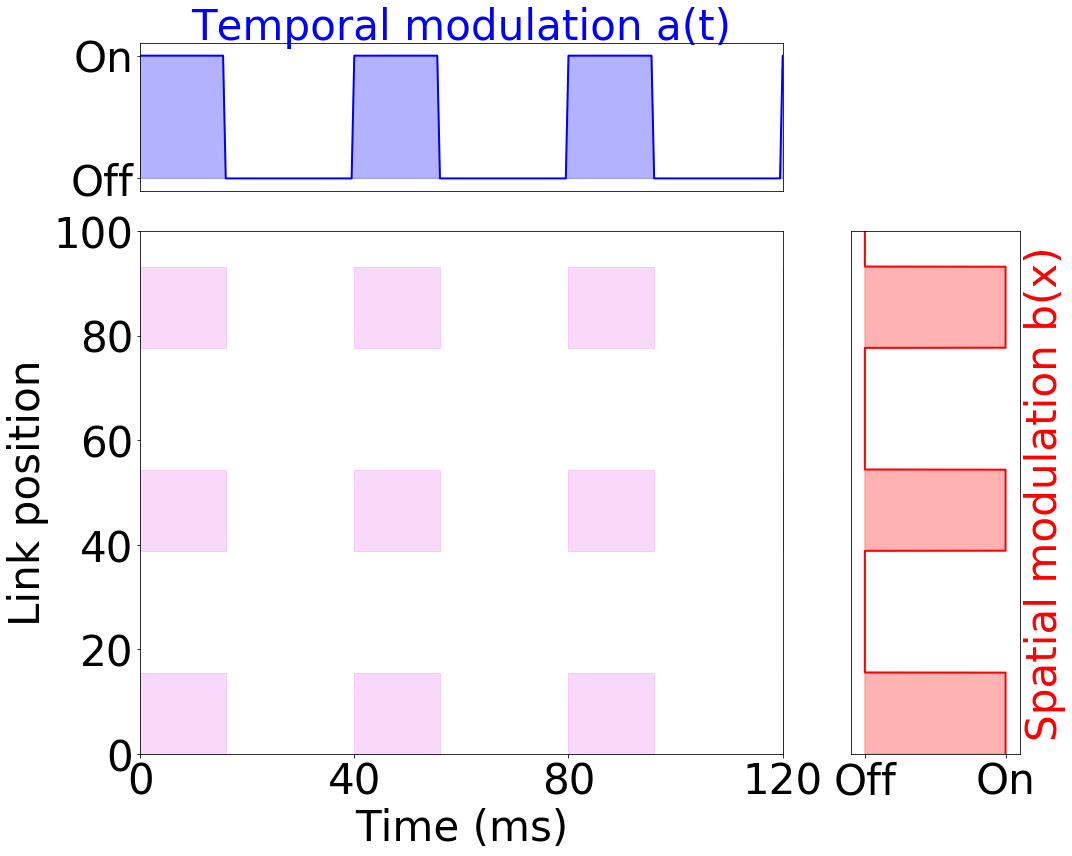

In [5]:
fig, axs = plot_czone(
    ctl_prm=to_ch_units(v_f_ch=1165, v_s_ch=570, v_f=M.V_F, w=M.W, h=M.H, t_p_ch=M.T_P_CH, verbose=True),
    figsize=(15, 12), gs=gridspec.GridSpec(4, 4))

axs[0].set_xlim(0, .12)
axs[0].set_yticklabels(['Off', 'On'])
axs[1].set_ylim(0, 100)
axs[1].set_xticklabels(['Off', 'On'])
axs[2].set_xlim(0, .12)
axs[2].set_xticks([0, .04, .08, .12])
axs[2].set_xticklabels([0, 40, 80, 120])
axs[2].set_ylim(0, 100)

axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('Link position')

for ax in axs:
    set_font_size(ax, 42)
    
fig.savefig('cosyne_poster_figs/fig3b.svg')

# Simulation functions

In [6]:
def set_up_ntwk(m, axs_w=None):
    m.N_E = m.N_L*m.N_L_E
    m.ctl_prm = to_ch_units(
        v_f_ch=1165, v_s_ch=570, v_f=m.V_F, w=m.W, h=m.H,
        t_p_ch=m.T_P_CH, t_p_ch_adj=m.T_P_CH_ADJ, x_p_ch_adj=m.X_P_CH_ADJ)
    
    # spatial modulation
    x_b = np.arange(m.N_L)
    b = .5 * (signal.square((2*np.pi/m.ctl_prm.x_p_ch)*x_b, m.ctl_prm.h) + 1)

    ## positional labels
    x = np.tile(x_b[:, None], (1, m.N_L_E)).flatten()

    ## x-modulated inp weight
    w_u_e_i_diag = m.W_U_E_I * np.tile(b[:, None], (1, m.N_L_E)).flatten()

    # full weight matrices
    ## E-E weights
    w_r_e_e = \
        m.W_E_E_R * np.kron(np.eye(m.N_L, k=0), np.ones([m.N_L_E]*2)) + \
        m.W_E_E_F * np.kron(np.eye(m.N_L, k=-1), np.ones([m.N_L_E]*2))  # btwn links

    w_r = {
        'E': w_r_e_e,
        'I': np.zeros((m.N_E, m.N_E)),
    }

    ## input weights
    w_u = {
        'E': np.block([
            [ m.W_E_E_F*np.ones([m.N_L_E]*2), np.zeros([m.N_L_E, m.N_E]) ],
            [ np.zeros([m.N_E-m.N_L_E,m.N_L_E*(m.N_L+1)]) ],
        ]),

        'I': np.block([
            [np.zeros([m.N_E, m.N_L_E]), np.diag(w_u_e_i_diag)],
        ])
    }

    # final network
    ntwk = LIFNtwkG(
        c_m=m.C_M_E,
        g_l=m.G_L_E,
        e_l=m.E_L_E,
        v_th=m.V_TH_E,
        v_r=m.E_L_E,
        t_r=m.T_R_E,
        e_s={'E': m.E_E, 'I': m.E_I},
        t_s={'E': m.T_E, 'I': m.T_E},
        w_r=w_r,
        w_u=w_u)

    ntwk.x = x.copy()
    ntwk.clamp = Generic(v={0: np.repeat(m.E_L_E, m.N_E)}, spk={})
    
    # helpful plots
    if axs_w is not None:
        axs_w[0].matshow(ntwk.w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs_w[0].set_title('W_R[E]')
        axs_w[1].matshow(ntwk.w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
        axs_w[1].set_title('W_R[I]')

        axs_w[2].matshow(ntwk.w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs_w[2].set_title('W_U[E]')
        axs_w[3].spy(ntwk.w_u['I'], markersize=1)
        axs_w[3].set_title('W_U[I]')

        for ax in axs_w.flatten():
            set_font_size(ax, 14)
    
    return ntwk


def set_up_inp(m, t_trg, s=None, ax_i_ext=None):
    if s is None:
        s = S
        
    t = np.arange(0, s.T, s.DT)
    
    # external noise
    i_ext = m.SGM_N/s.DT * np.random.randn(len(t), m.N_E)
    
    if ax_i_ext is not None:

        # input current
        ax_i_ext.plot(1000*t, 1e6*i_ext[:, :50])
        ax_i_ext.set_xlim(1000*t.min(), 1000*t.max())

        ax_i_ext.set_ylabel('I_in (uA)')
        ax_i_ext.set_xlabel('Time (ms)')
        set_font_size(ax_i_ext, 14)
    
    # temporal inh modulation
    a = .5 * (signal.square((2*np.pi/m.ctl_prm.t_p_ch)*t, m.ctl_prm.w) + 1)

    spks_u_inh = np.zeros((len(t), m.N_L_E + m.N_E), dtype=int)
    spks_u_inh[:, m.N_L_E:] = np.random.poisson(np.array(a * m.FQ_SPK_U_I * s.DT)[:, None], (len(t), m.N_E))

    d_trg = .002

    t_mask = (t_trg <= t) & (t < (t_trg + d_trg))
    tmp = cc([np.ones(m.N_L_E, int), np.zeros(m.N_L_E*(t_mask.sum()-1))])

    spks_u_trg = np.zeros((len(t), m.N_L_E + m.N_E), dtype=int)
    spks_u_trg[t_mask, :m.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_L_E)
    
    return i_ext, spks_u_inh, spks_u_trg

## Run simulation

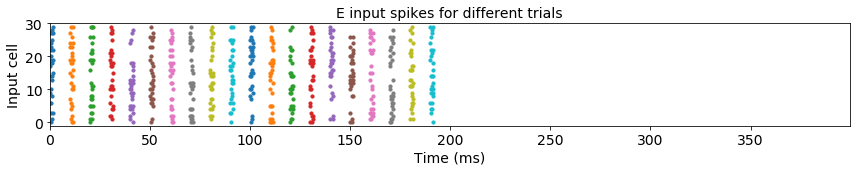

In [7]:
fig, ax_trg = plt.subplots(1, 1, figsize=(12, 2.5), tight_layout=True)

m = copy(M)
ntwk = set_up_ntwk(m, axs_w=None)

rsps = []
for t_trg in .000 + .01*np.arange(20, dtype=float):

    i_ext, spks_u_inh, spks_u_trg = set_up_inp(m, t_trg)
    spks_u = spks_u_inh + spks_u_trg

    rsp = ntwk.run(dt=S.DT, clamp=ntwk.clamp, i_ext=i_ext, spks_u=spks_u)

    rsps.append(copy(rsp))

    t_spk_u_trg, c_spk_u_trg = np.nonzero(spks_u_trg[:, :m.N_L_E])
    t_spk_u_trg = t_spk_u_trg * S.DT

    # input spikes
    ax_trg.scatter(1000*t_spk_u_trg, c_spk_u_trg, s=10)

if ax_trg is not None:
    ax_trg.set_ylim(-1, m.N_L_E)
    ax_trg.set_title('E input spikes for different trials'.format(1000*t_trg))
    ax_trg.set_ylabel('Input cell')

    ax_trg.set_xlim(1000*rsps[0].t.min(), 1000*rsps[0].t.max())
    ax_trg.set_xlabel('Time (ms)')
    set_font_size(ax_trg, 14)

## Plot functions

In [8]:
def plot_raster(m, rsps, ax):

    # plot results (spks and voltage for each chain link)
    c = get_spaced_colors('hsv', m.N_L, 75/256)
    v_space = 1.5 * (m.V_TH_E - m.E_I)
    
    for rsp in rsps:
        t_spk_all = []
        x_spk_all = []

        for l_ctr in range(m.N_L):
            # spks & voltages for this link
            idx_start = l_ctr * m.N_L_E
            idx_end = (l_ctr+1) * m.N_L_E

            # raster
            t_spk, c_spk = rsp.spks[:, idx_start:idx_end].nonzero()
            t_spk = t_spk*S.DT
            c_spk = c_spk + idx_start

            # convert to chain link position
            x_spk = ntwk.x[c_spk]

            ax.scatter(1000*t_spk, x_spk + .2 * np.random.randn(len(x_spk)), s=5, c=[c[l_ctr]], zorder=0)

            t_spk_all.extend(list(t_spk))
            x_spk_all.extend(list(x_spk))

        # fit/plot line
        if len(t_spk_all) >= 2:
            slp, icpt = stats.linregress(t_spk_all, x_spk_all)[:2]
            t_line = np.array([np.min(t_spk_all), np.max(t_spk_all)])
            x_line = slp*t_line + icpt
            ax.plot(1000*t_line, x_line, lw=1, c='gray', zorder=1)

    ax.set_ylim(-1, m.N_L)
    ax.set_ylabel('Link position')
    ax.set_title('Raster')

    ax.grid()

    ax.set_xlim(1000*rsp.t.min(), 1000*rsp.t.max())
    ax.set_xlabel('Time (ms)')
    set_font_size(ax, 16)
    

def plot_czone_overlay(m, rsps, s=S, t_wdw=.002, c=None, figsize=(12, 10), gs=None):
        
    # estimate position from chain activity and overlay atop correction zones
    fig, axs = plot_czone(m.ctl_prm, m=m, s=s, figsize=figsize, gs=gs)
    if c is None:
        c = get_spaced_colors('hsv', m.N_L, 75/256)

    for rsp, c_ in zip(rsps, c):
        x_est = np.nan * np.zeros(len(rsp.t))
        for ct, t_ in enumerate(rsp.t):
            t_mask = (t_ - t_wdw/2 <= rsp.t) & (rsp.t < t_ + t_wdw/2)
            spks_wdw = rsp.spks[t_mask, :]
            spk_c = spks_wdw.nonzero()[1]

            if len(spk_c) > 3:
                x_est[ct] = np.median(ntwk.x[spk_c])

        axs[2].plot(rsp.t, x_est, color=c_)
        
    return fig, axs

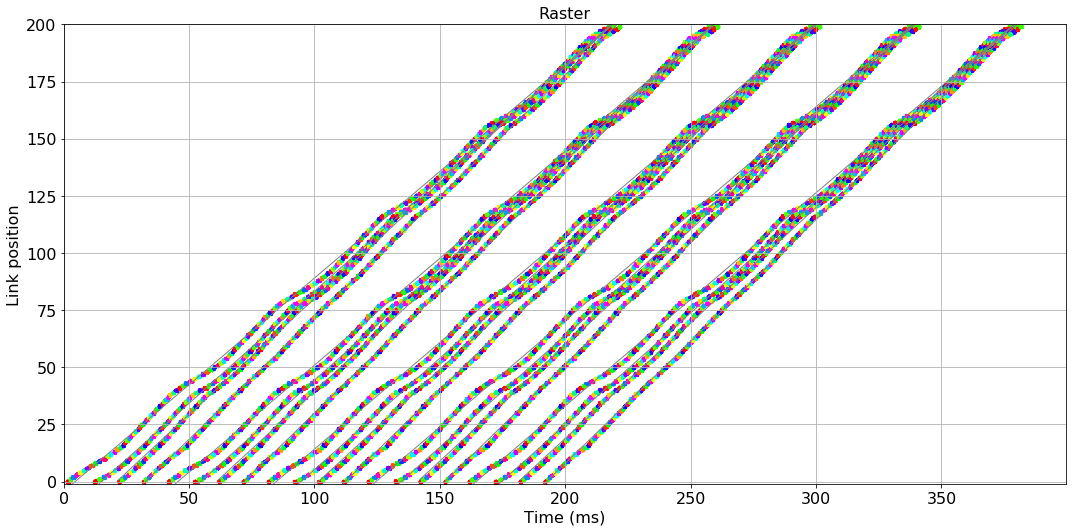

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5), tight_layout=True)
plot_raster(m, rsps, ax)

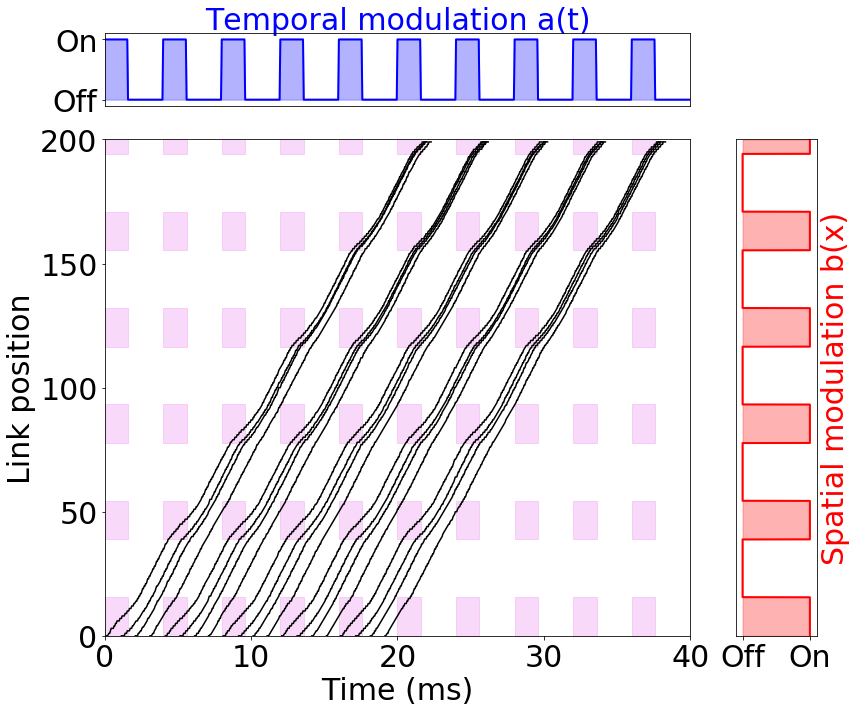

In [10]:
fig, axs = plot_czone_overlay(m, rsps, c=[(0, 0, 0)]*len(rsps))

axs[0].set_yticklabels(['Off', 'On'])
axs[1].set_xticklabels(['Off', 'On'])
axs[2].set_xticks([0, .1, .2, .3, .4])
axs[2].set_xticklabels([0, 10, 20, 30, 40])
axs[2].set_yticks([0, 50, 100, 150, 200])

axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('Link position')

for ax in axs:
    set_font_size(ax, 30)
    
fig.savefig('cosyne_poster_figs/fig3c.svg')

Repeat for unhelpful correction zones

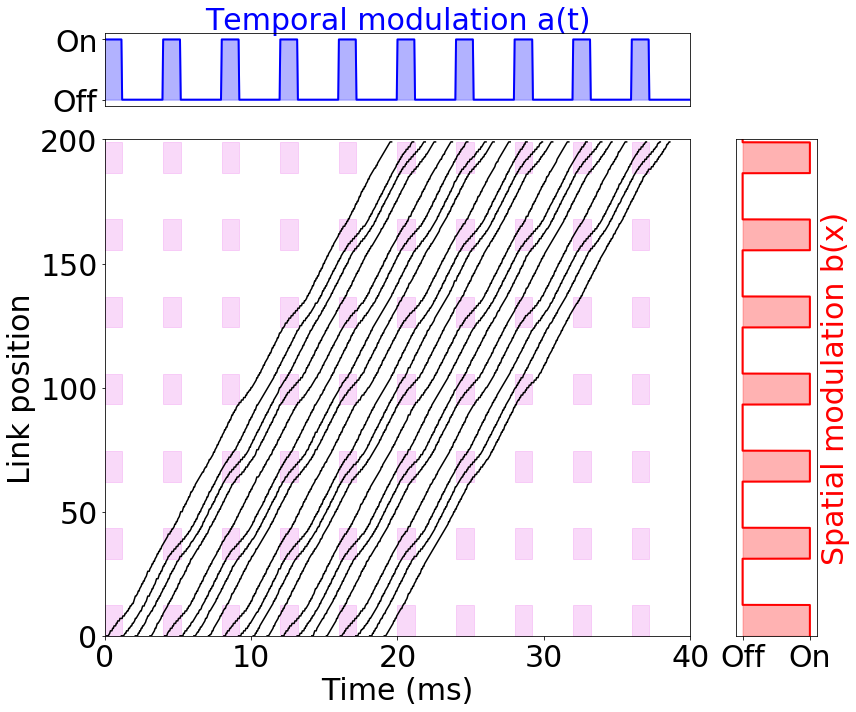

In [11]:
m = copy(M)
m.V_F = 1.5
m.W = .3
ntwk = set_up_ntwk(m, axs_w=None)

rsps = []
for t_trg in .000 + .01*np.arange(20, dtype=float):

    i_ext, spks_u_inh, spks_u_trg = set_up_inp(m, t_trg)
    spks_u = spks_u_inh + spks_u_trg

    rsp = ntwk.run(dt=S.DT, clamp=ntwk.clamp, i_ext=i_ext, spks_u=spks_u)

    rsps.append(copy(rsp))

    t_spk_u_trg, c_spk_u_trg = np.nonzero(spks_u_trg[:, :m.N_L_E])
    t_spk_u_trg = t_spk_u_trg * S.DT

fig, axs = plot_czone_overlay(m, rsps, c=[(0, 0, 0)]*len(rsps))

axs[0].set_yticklabels(['Off', 'On'])
axs[1].set_xticklabels(['Off', 'On'])
axs[2].set_xticks([0, .1, .2, .3, .4])
axs[2].set_xticklabels([0, 10, 20, 30, 40])
axs[2].set_yticks([0, 50, 100, 150, 200])

axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('Link position')

for ax in axs:
    set_font_size(ax, 30)
    
fig.savefig('cosyne_poster_figs/fig3d.svg')

Repeat for temporally uniform inhibition

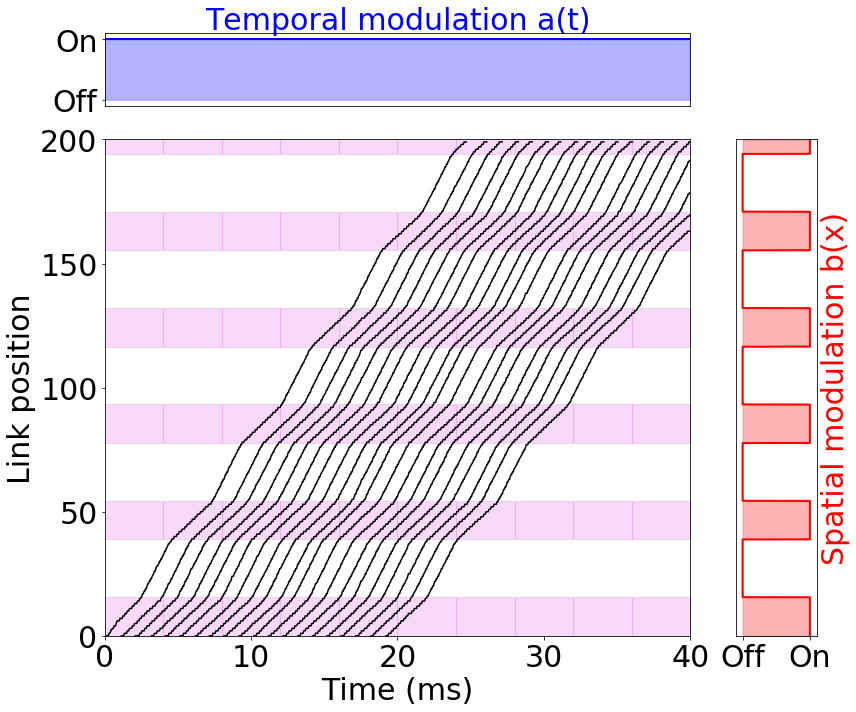

In [12]:
m = copy(M)
m.W = 1
ntwk = set_up_ntwk(m, axs_w=None)

rsps = []
for t_trg in .000 + .01*np.arange(20, dtype=float):

    i_ext, spks_u_inh, spks_u_trg = set_up_inp(m, t_trg)
    spks_u = spks_u_inh + spks_u_trg

    rsp = ntwk.run(dt=S.DT, clamp=ntwk.clamp, i_ext=i_ext, spks_u=spks_u)

    rsps.append(copy(rsp))

    t_spk_u_trg, c_spk_u_trg = np.nonzero(spks_u_trg[:, :m.N_L_E])
    t_spk_u_trg = t_spk_u_trg * S.DT

fig, axs = plot_czone_overlay(m, rsps, c=[(0, 0, 0)]*len(rsps))

axs[0].set_yticklabels(['Off', 'On'])
axs[1].set_xticklabels(['Off', 'On'])
axs[2].set_xticks([0, .1, .2, .3, .4])
axs[2].set_xticklabels([0, 10, 20, 30, 40])
axs[2].set_yticks([0, 50, 100, 150, 200])

axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('Link position')

for ax in axs:
    set_font_size(ax, 30)
    
fig.savefig('cosyne_poster_figs/fig3e.svg')

Repeat for spatially uniform inhibition

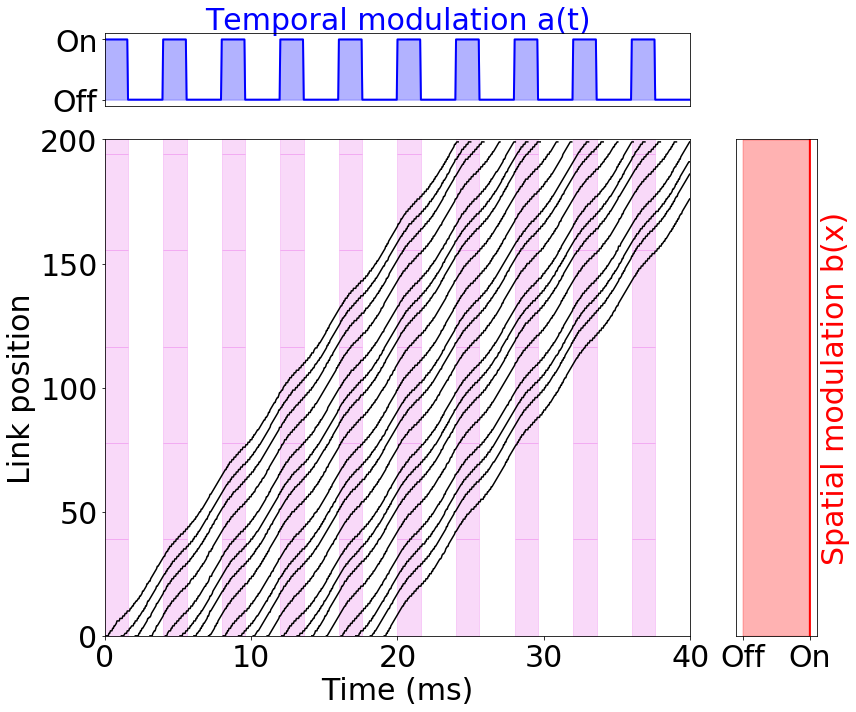

In [13]:
m = copy(M)
m.H = 1
ntwk = set_up_ntwk(m, axs_w=None)

rsps = []
for t_trg in .000 + .01*np.arange(20, dtype=float):

    i_ext, spks_u_inh, spks_u_trg = set_up_inp(m, t_trg)
    spks_u = spks_u_inh + spks_u_trg

    rsp = ntwk.run(dt=S.DT, clamp=ntwk.clamp, i_ext=i_ext, spks_u=spks_u)

    rsps.append(copy(rsp))

    t_spk_u_trg, c_spk_u_trg = np.nonzero(spks_u_trg[:, :m.N_L_E])
    t_spk_u_trg = t_spk_u_trg * S.DT

fig, axs = plot_czone_overlay(m, rsps, c=[(0, 0, 0)]*len(rsps))

axs[0].set_yticklabels(['Off', 'On'])
axs[1].set_xticklabels(['Off', 'On'])
axs[2].set_xticks([0, .1, .2, .3, .4])
axs[2].set_xticklabels([0, 10, 20, 30, 40])
axs[2].set_yticks([0, 50, 100, 150, 200])

axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('Link position')

for ax in axs:
    set_font_size(ax, 30)
    
fig.savefig('cosyne_poster_figs/fig3f.svg')

## Speed control

In [14]:
m = copy(M)
m.N_L = 500
m.H = .4

s = copy(S)
s.T = 0.55

t_p_ch_adj = [.92, 1, 1.05]

rsps = []
ms = []

for t_p_ch_adj_ in t_p_ch_adj:
    m.T_P_CH_ADJ = t_p_ch_adj_


    ntwk = set_up_ntwk(m, axs_w=None)

    t_trg = 0.01

    i_ext, spks_u_inh, spks_u_trg = set_up_inp(m, t_trg, s)
    spks_u = spks_u_inh + spks_u_trg

    rsp = ntwk.run(dt=S.DT, clamp=ntwk.clamp, i_ext=i_ext, spks_u=spks_u)
    
    rsps.append(copy(rsp))
    ms.append(copy(m))

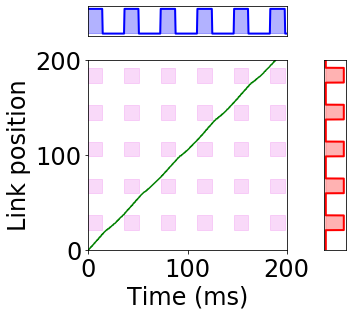

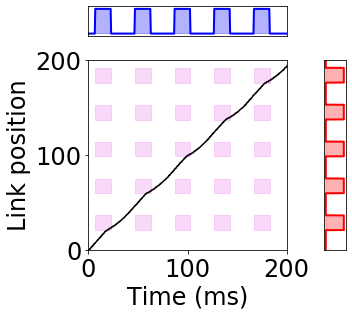

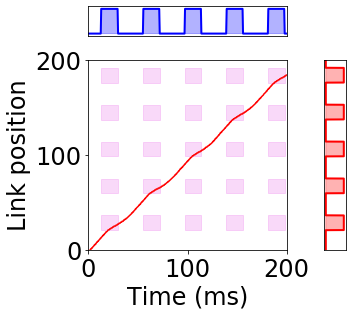

In [15]:
x_min = [.295, .313, .323]
c = [[0, .5, 0], [0, 0, 0], [1, 0, 0]]
gs = gridspec.GridSpec(5, 5)

for ctr, (rsp, m, x_min_, c_) in enumerate(zip(rsps, ms, x_min, c)):
    fig, axs = plot_czone_overlay(m, [rsp], s, figsize=(5, 4.5), c=[c_], gs=gs)
    axs[0].set_xlim(x_min_, x_min_ + .2)
    axs[1].set_ylim(290, 490)
    axs[2].set_xlim(x_min_, x_min_ + .2)
    axs[2].set_ylim(290, 490)
    
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    
    axs[1].xaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)
    
    axs[2].set_xticks([x_min_ + offset for offset in .1*np.arange(3)])
    #axs[2].set_xticklabels([25, 75, 125, 175])
    axs[2].set_xticklabels([0, 100, 200])
    
    axs[2].set_yticks([290, 390, 490])
    axs[2].set_yticklabels([0, 100, 200])
    
    axs[2].set_xlabel('Time (ms)')
    axs[2].set_ylabel('Link position')
    
    for ax in axs:
        set_font_size(ax, 24)
        
    fig.savefig('cosyne_poster_figs/fig3g{}.svg'.format(ctr+1))